In [ ]:
"""
Complete Portfolio Backtest Script
- Downloads data from Yahoo Finance
- Splits train/test automatically
- Builds Equal-Weight, Min-Variance, and Max-Sharpe portfolios
- Calculates performance metrics and plots equity curves
"""

In [17]:
from __future__ import annotations
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

try:
    import cvxpy as cp
    _HAS_CVXPY = True
except Exception:
    _HAS_CVXPY = False

In [18]:
# ===================== Parameters ===================== #
TICKERS = ["SPY", "AGG", "GLD", "QQQ"]
START_DATE = "2017-01-01"
END_DATE   = "2023-08-30"
TRAIN_START = "2017-01-03"
TRAIN_END   = "2021-12-31"
TEST_START  = "2022-01-01"
TEST_END    = "2023-08-30"
REBALANCE_FREQ = 'M'
RF_ANNUAL = 0.01
OUT_DIR = 'out'
os.makedirs(OUT_DIR, exist_ok=True)

In [23]:
# ===================== Utilities ===================== #
def fetch_prices_yahoo(tickers: list, start: str, end: str) -> pd.DataFrame:
    print(f"Downloading data for {tickers} from {start} to {end}...")
    data = yf.download(tickers, start=start, end=end, progress=False, auto_adjust=False)
    if isinstance(data.columns, pd.MultiIndex):
        if 'Adj Close' in data.columns.levels[0]:
            data = data['Adj Close']
        else:
            data = data.xs('Close', axis=1, level=0)
    elif 'Adj Close' in data.columns:
        data = data['Adj Close']
    else:
        raise ValueError("Could not find 'Adj Close' or 'Close' in downloaded data.")
    data = data.sort_index().ffill().dropna()
    return data

def to_returns(prices: pd.DataFrame) -> pd.DataFrame:
    return prices.pct_change().dropna(how='all')

def annualize_return(daily_ret: pd.Series, freq: int = 252) -> float:
    if daily_ret.empty:
        return np.nan
    cum = (1 + daily_ret).prod()
    years = len(daily_ret) / freq
    return cum ** (1/years) - 1 if years > 0 else np.nan

def annualize_vol(daily_ret: pd.Series, freq: int = 252) -> float:
    return daily_ret.std() * np.sqrt(freq) if not daily_ret.empty else np.nan

def sharpe_ratio(daily_ret: pd.Series, rf_annual: float = 0.0, freq: int = 252) -> float:
    if daily_ret.empty or daily_ret.std() == 0:
        return np.nan
    rf_daily = (1 + rf_annual) ** (1/freq) - 1
    excess = daily_ret - rf_daily
    return excess.mean() / excess.std() * np.sqrt(freq)

def max_drawdown(cum_curve: pd.Series) -> float:
    roll_max = cum_curve.cummax()
    drawdown = cum_curve / roll_max - 1.0
    return drawdown.min() if not drawdown.empty else 0.0

# ===================== Portfolio Construction ===================== #
def equal_weight(n_assets: int) -> np.ndarray:
    return np.ones(n_assets) / n_assets

def min_variance_portfolio(cov: np.ndarray) -> np.ndarray:
    n = cov.shape[0]
    w = cp.Variable(n)
    prob = cp.Problem(cp.Minimize(cp.quad_form(w, cov)), [cp.sum(w) == 1, w >= 0])
    prob.solve(solver=cp.SCS)
    return w.value if w.value is not None else equal_weight(n)

# Max Sharpe (linearized)
def max_sharpe_portfolio(mean_ret, cov, rf=0.0):
    n = len(mean_ret)
    w = cp.Variable(n)
    ret = mean_ret @ w
    risk = cp.quad_form(w, cov)
    prob = cp.Problem(cp.Maximize(ret - rf * cp.sum(w) - 0.5*risk), [cp.sum(w)==1, w>=0])
    prob.solve(solver=cp.SCS)
    return w.value if w.value is not None else np.ones(n)/n

In [24]:
# ===================== Backtest ===================== #
def backtest_portfolio(rets: pd.DataFrame, weights: np.ndarray) -> pd.Series:
    return (rets @ weights)

Loaded 1675 days x 4 assets
Data covers 2017-01-03 → 2023-08-29


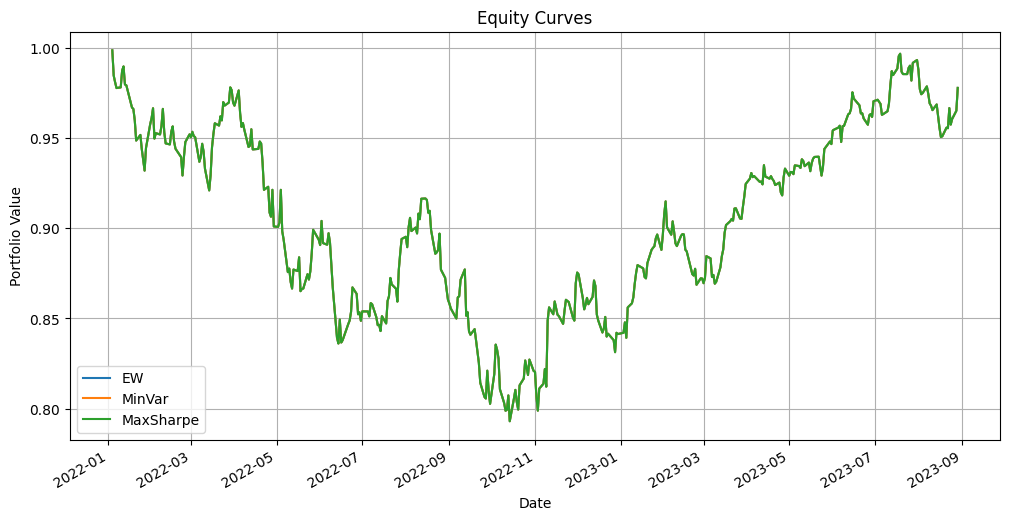

Portfolio Weights (Train Period):
       EW  MinVar  MaxSharpe
SPY  0.25    0.25       0.25
AGG  0.25    0.25       0.25
GLD  0.25    0.25       0.25
QQQ  0.25    0.25       0.25
Performance Metrics (Test Period):
              EW    MinVar  MaxSharpe
CAGR   -0.013611 -0.013611  -0.013611
Vol     0.138584  0.138584   0.138584
Sharpe -0.029791 -0.029791  -0.029791
MaxDD  -0.205694 -0.205694  -0.205694


In [25]:
# ===================== Main ===================== #
def main():
    prices = fetch_prices_yahoo(TICKERS, START_DATE, END_DATE)
    print(f"Loaded {prices.shape[0]} days x {prices.shape[1]} assets")
    print(f"Data covers {prices.index.min().date()} → {prices.index.max().date()}")

    # Trim train/test periods to available data
    train_start_dt = max(pd.to_datetime(TRAIN_START), prices.index.min())
    train_end_dt   = min(pd.to_datetime(TRAIN_END), prices.index.max())
    test_start_dt  = max(pd.to_datetime(TEST_START), prices.index.min())
    test_end_dt    = min(pd.to_datetime(TEST_END), prices.index.max())

    train = to_returns(prices.loc[train_start_dt:train_end_dt])
    test  = to_returns(prices.loc[test_start_dt:test_end_dt])

    # Portfolio construction on train set
    mean_ret = train.mean().values
    cov = train.cov().values

    ew_weights = equal_weight(len(TICKERS))
    minvar_weights = min_variance_portfolio(cov) if _HAS_CVXPY else ew_weights
    maxsharpe_weights = max_sharpe_portfolio(mean_ret, cov, RF_ANNUAL/252) if _HAS_CVXPY else ew_weights

    # Backtest
    ew_ret = backtest_portfolio(test, ew_weights)
    minvar_ret = backtest_portfolio(test, minvar_weights)
    maxsharpe_ret = backtest_portfolio(test, maxsharpe_weights)

    # Performance summary
    summary = pd.DataFrame({
        'EW': ew_ret,
        'MinVar': minvar_ret,
        'MaxSharpe': maxsharpe_ret
    })

    cum_summary = (1 + summary).cumprod()
    cum_summary.plot(figsize=(12,6), title='Equity Curves')
    plt.xlabel('Date'); plt.ylabel('Portfolio Value'); plt.grid(True)
    plt.savefig(os.path.join(OUT_DIR, 'equity_curves.png'))
    plt.show()

    print("Portfolio Weights (Train Period):")
    print(pd.DataFrame({'EW': ew_weights, 'MinVar': minvar_weights, 'MaxSharpe': maxsharpe_weights}, index=TICKERS))

    print("Performance Metrics (Test Period):")
    metrics = summary.apply(lambda x: pd.Series({
        'CAGR': annualize_return(x),
        'Vol': annualize_vol(x),
        'Sharpe': sharpe_ratio(x),
        'MaxDD': max_drawdown((1+x).cumprod())
    }))
    print(metrics)

if __name__ == '__main__':
    main()
